# Developing and tuning a RandomForest Classifier

In this notebook, the yoghurt data with dummy variables is used to build and tune a RandomForest Classifier.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Load data and remove irrelevant variables

In [2]:
data = pd.read_csv("../02_data_preparation/yoghurt_w_dummy_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21251 entries, 0 to 21250
Data columns (total 67 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 21251 non-null  int64  
 1   first_purchase             21251 non-null  bool   
 2   shelf_price                21251 non-null  float64
 3   pct_disc                   21251 non-null  float64
 4   pct_retail_disc            21251 non-null  float64
 5   pct_coupon_disc            21251 non-null  float64
 6   display_1                  21251 non-null  int64  
 7   display_2                  21251 non-null  int64  
 8   display_3                  21251 non-null  int64  
 9   display_4                  21251 non-null  int64  
 10  display_5                  21251 non-null  int64  
 11  display_6                  21251 non-null  int64  
 12  display_7                  21251 non-null  int64  
 13  display_9                  21251 non-null  int

In [3]:
data.drop(labels=["Unnamed: 0", "display_1", "display_5", "display_A", "campaign_6.0", "campaign_30.0", "description_TypeC"],
          axis = 1, inplace = True)

In [4]:
pd.set_option("display.max_columns", None)
data.describe(include = "all")

,first_purchase,shelf_price,pct_disc,pct_retail_disc,pct_coupon_disc,display_2,display_3,display_4,display_6,display_7,display_9,mailer_A,mailer_C,mailer_D,mailer_H,mailer_J,marital_status_A,marital_status_B,homeowner_Homeowner,homeowner_Probable Owner,homeowner_Probable Renter,homeowner_Renter,hhcomp_1 Adult Kids,hhcomp_2 Adults Kids,hhcomp_2 Adults No Kids,hhcomp_Single Female,hhcomp_Single Male,kid_category_1,kid_category_2,kid_category_3+,kid_category_None/Unknown,age_19-24,age_25-34,age_35-44,age_45-54,age_55-64,age_65+,income_100-124K,income_125-149K,income_15-24K,income_150-174K,income_175-199K,income_200-249K,income_25-34K,income_250K+,income_35-49K,income_50-74K,income_75-99K,income_Under 15K,hhsize_1,hhsize_2,hhsize_3,hhsize_4,hhsize_5+,campaign_8.0,campaign_13.0,campaign_18.0,campaign_29.0,description_TypeA,description_TypeB
count,21251,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.00000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,14083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.156933,0.158316,0.153330,0.004987,0.011152,0.007623,0.001082,0.005459,0.012046,0.004047,0.148699,0.001223,0.048751,0.008235,0.005270,0.488918,0.125406,0.686321,0.015152,0.005176,0.037834,0.061974,0.295092,0.314009,0.147711,0.122677,0.159240,0.098537,0.102254,0.63997,0.042727,0.211896,0.276975,0.347701,0.067009,0.053692,0.080420,0.074820,0.054586,0.085972,0.017646,0.006870,0.079384,0.017646,0.180086,0.224037,0.126394,0.052139,0.280975,0.374476,0.156746,0.089596,0.098207,0.076373,0.077879,0.075855,0.006776,0.230248,0.006776
std,NaN,1.104681,0.145841,0.137543,0.044610,0.105017,0.086979,0.032881,0.073682,0.109096,0.063488,0.355800,0.034958,0.215351,0.090374,0.072407,0.499889,0.331186,0.463999,0.122161,0.071761,0.190798,0.241113,0.456095,0.464131,0.354821,0.328073,0.365908,0.298046,0.302989,0.48002,0.202247,0.408661,0.447515,0.476252,0.250043,0.225413,0.271948,0.263107,0.227175,0.280330,0.131665,0.082604,0.270344,0.131665,0.384268,0.416956,0.332301,0.222312,0.449486,0.483999,0.363569,0.285609,0.297602,0.265600,0.267987,0.264773,0.082040,0.421001,0.082040
min,NaN,0.350000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.400000,0.

## Build initial Random Forest model

Importing modules, splitting data in test and train data and fitting an initial RandomForest Classifier

In [4]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import learning_curve, validation_curve

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [5]:
X = data.drop("first_purchase", axis = 1)
y = data["first_purchase"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, stratify = y)

The data has a certain structure based on households, products, and time during the observation period. In order to avoid the risk of systematic effects, StratifiedShuffleSplit is selected for cross-validation instead of StratifiedKFold.

In [7]:
cv = StratifiedShuffleSplit(n_splits = 5) 

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
rf = RandomForestClassifier(n_jobs = -1)

In [26]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [27]:
#crossval metrics for rf model - TRAIN
scores = ["f1", "precision", "recall", "accuracy"]

for score in scores:
    list_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring = score )
    print(list_scores.mean())

0.6213111061462783
0.6829732541478295
0.5710296684118674
0.76


In [28]:
#metrics for rf model - TEST
scores = [f1_score, precision_score, recall_score, accuracy_score]

for score in scores:
    print(score(y_test, y_pred_rf))

0.625633034670822
0.7087378640776699
0.5599721059972106
0.7739355445777464


The initial model looks quite promising already.

In [29]:
y_pred_rf_train = rf.predict(X_train)
#metrics for rf model- TRAIN
scores = [f1_score, precision_score, recall_score, accuracy_score]

for score in scores:
    print(score(y_train, y_pred_rf_train))

0.7721762555320377
0.8611587982832618
0.6998604813393792
0.8607058823529412


In [30]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Hyperparameter tuning

We begin hyperparameter tuning with random search for a few key hyperparameters. However, this does not help improve the model.

In [18]:
import scipy

In [31]:
rand_params_rf = {"n_estimators": scipy.stats.randint(50, 300), 'max_depth': scipy.stats.randint(2, 40), 
                  "min_samples_leaf": scipy.stats.randint(5,100), "min_samples_split": scipy.stats.randint(5,100)}

In [32]:
rand_rf = RandomizedSearchCV(rf, rand_params_rf, n_iter=30, scoring = "f1", cv = cv)

In [33]:
rand_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
                   estimator=RandomForestClassifier(n_jobs=-1), n_iter=30,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002072C00D0A0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002072C012430>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002072C00D520>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002072BF717C0>},
                   scoring='f1')

In [34]:
rand_rf.best_score_

0.46457638534213486

In [35]:
rand_rf.best_estimator_

RandomForestClassifier(max_depth=36, min_samples_leaf=7, min_samples_split=21,
                       n_estimators=254, n_jobs=-1)

## Validation with initial RandomForest model

We proceed with the initial RandomForest model which already had quite good scores.
Learning curve and validation curves show that the model is learning, but it also overfits.
Indications for improving the model are derived from cross validation curves.

In [10]:
from plotting import plot_learning_curve, plot_validation_curve

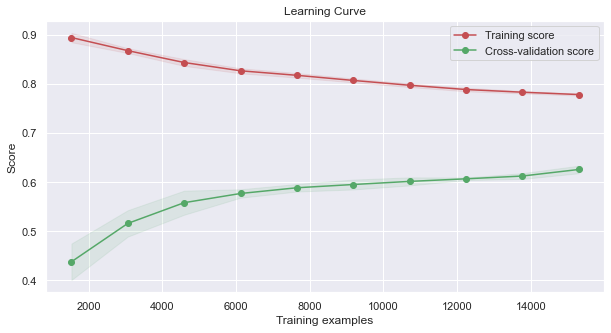

In [40]:
learning_curve = plot_learning_curve(rf, X_train, y_train, cv = cv,  
                          train_sizes = np.linspace(0.1, 1, 10), scoring = "f1")           

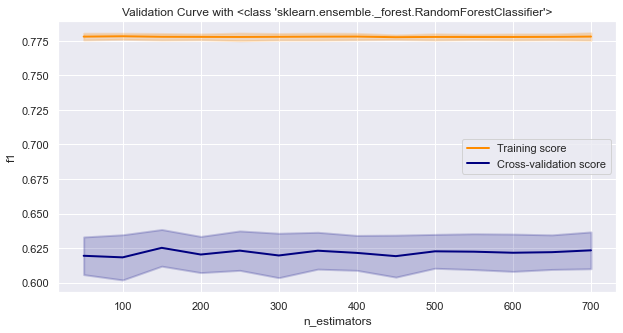

In [58]:
val_n_estimators = plot_validation_curve(rf, X_train, y_train, cv = cv, 
                                      param_name ="n_estimators", param_range = np.arange(50,750,50), scoring = "f1")

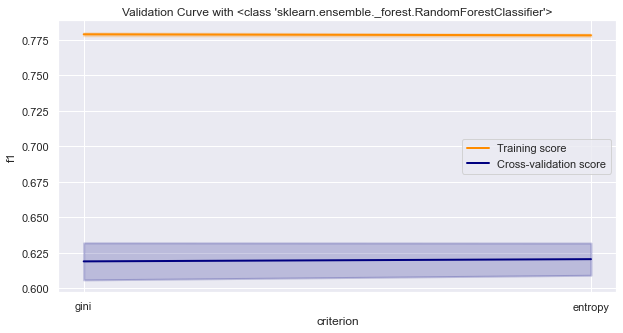

In [42]:
val_criterion = plot_validation_curve(rf, X_train, y_train, cv=cv,
                                             param_name="criterion", param_range = ["gini", "entropy"], scoring = "f1")

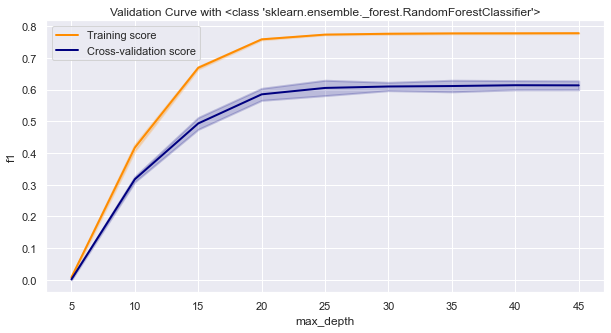

In [43]:
val_max_depth = plot_validation_curve(rf, X_train, y_train, cv=cv,
                                              param_name = "max_depth", param_range = np.arange(5,50,5), scoring="f1")

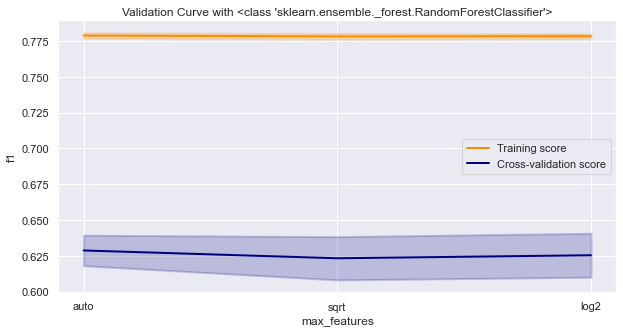

In [45]:
val_max_features = plot_validation_curve(rf, X_train, y_train, cv=cv,
                                              param_name = "max_features", param_range = ["auto", "sqrt", "log2"], scoring="f1")

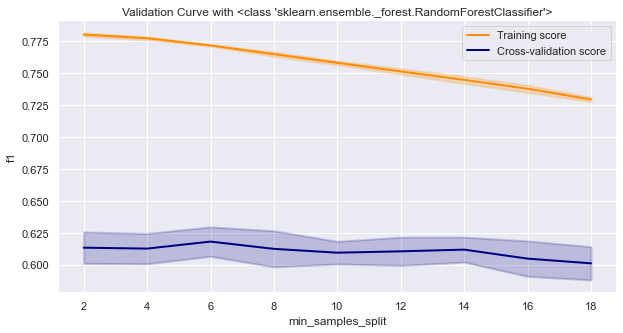

In [46]:
val_min_samples_split = plot_validation_curve(rf, X_train, y_train, cv=cv,
                                              param_name = "min_samples_split", param_range = np.arange(2, 20, 2), scoring="f1")

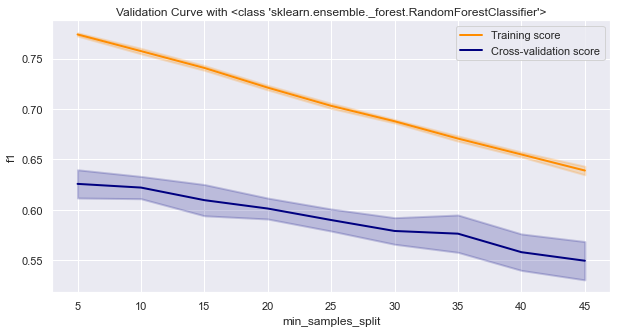

In [47]:
val_min_samples_split = plot_validation_curve(rf, X_train, y_train, cv=cv,
                                              param_name = "min_samples_split", param_range = np.arange(5, 50, 5), scoring="f1")

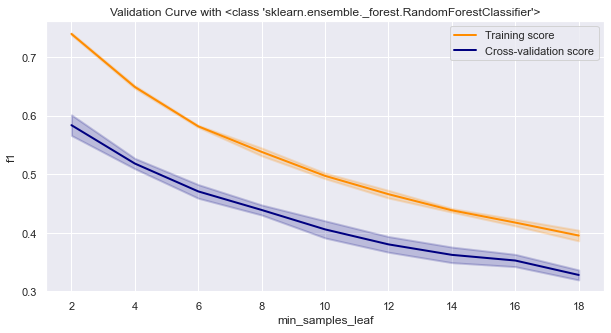

In [48]:
val_min_samples_leaf = plot_validation_curve(rf, X_train, y_train, cv=cv,
                                              param_name = "min_samples_leaf", param_range = np.arange(2, 20, 2), scoring="f1")

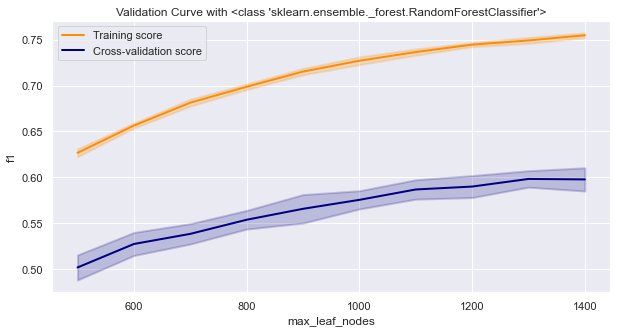

In [51]:
val_max_leaf_nodes = plot_validation_curve(rf, X_train, y_train, cv=cv,
                                              param_name = "max_leaf_nodes", param_range = np.arange(500, 1500, 100), scoring="f1")

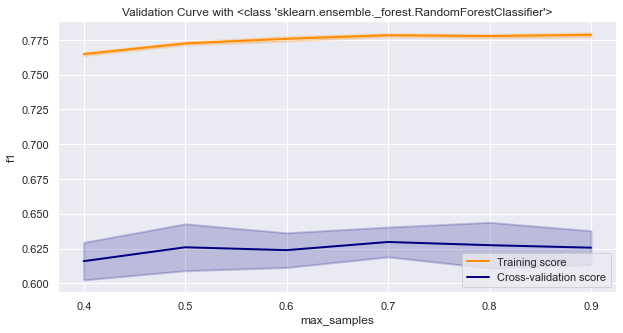

In [54]:
val_max_samples = plot_validation_curve(rf, X_train, y_train, cv=cv,
                                              param_name = "max_samples", param_range = np.arange(0.4, 1, 0.1), scoring="f1")

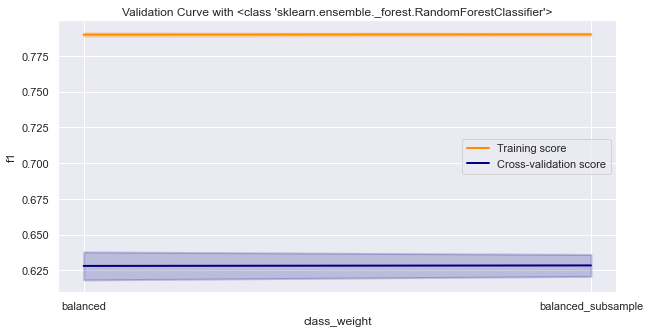

In [56]:
val_class_weight = plot_validation_curve(rf, X_train, y_train, cv=cv,
                                              param_name = "class_weight", param_range = ["balanced", "balanced_subsample"], scoring="f1")

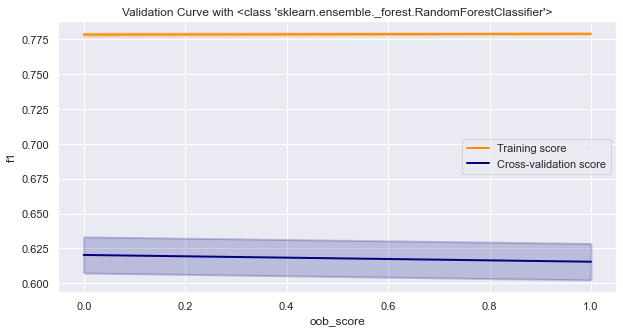

In [57]:
val_oob_score = plot_validation_curve(rf, X_train, y_train, cv=cv,
                                              param_name = "oob_score", param_range = [True, False], scoring="f1")

## Hyperparameter tuning based on initial model

Based on indications from crossvalidation curves, we define a new baseline model rf_2 and a parameter grid for grid search.

In [12]:
grid_params = {"n_estimators": [150, 250, 350], "max_depth": [20, 25, 30], "min_samples_split": [4, 6], "max_samples": [0.5, 0.7, 1]}

In [60]:
rf_2 = RandomForestClassifier(n_jobs = -1, class_weight = "balanced")

In [62]:
grid_search = GridSearchCV(rf_2, param_grid = grid_params, scoring = "f1", cv = cv)

In [63]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1),
             param_grid={'max_depth': [20, 25, 30],
                         'max_samples': [0.5, 0.7, 1],
                         'min_samples_split': [4, 6],
                         'n_estimators': [150, 250, 350]},
             scoring='f1')

In [64]:
grid_search.best_score_

0.6588600620478096

In [65]:
grid_search.best_params_

{'max_depth': 20,
 'max_samples': 0.7,
 'min_samples_split': 6,
 'n_estimators': 250}

The tuned model's cross-validation scores as well as the learning curve look promising

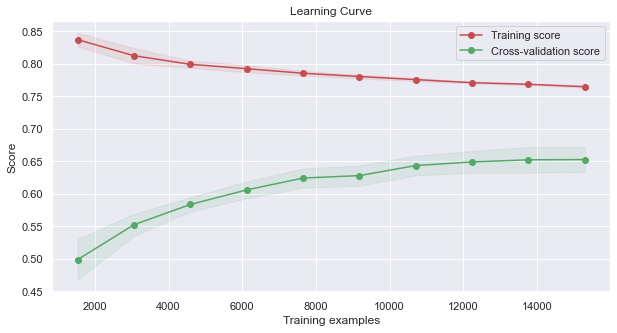

In [66]:
learning_curve = plot_learning_curve(grid_search.best_estimator_, X_train, y_train, cv = cv,  
                          train_sizes = np.linspace(.1, 1, 10), scoring = "f1")           

## Calculate model performance

Test scores are best scores so far across all investigated models. Still, overfitting remains a challenge.

In [67]:
rf_3 = RandomForestClassifier(n_jobs = -1, class_weight = "balanced",
                             max_depth = 20, max_samples = 0.7, min_samples_split = 6, n_estimators = 250)

In [68]:
rf_3.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, max_samples=0.7,
                       min_samples_split=6, n_estimators=250, n_jobs=-1)

In [69]:
#crossval metrics for rf_3 model
scores = ["f1", "precision", "recall", "accuracy"]

for score in scores:
    list_scores = cross_val_score(rf_3, X_train, y_train, cv=cv, scoring = score )
    print(list_scores.mean())

0.6516085695202584
0.6123562629505072
0.7089005235602095
0.7527058823529412


In [70]:
y_pred_rf_3 = rf_3.predict(X_test)
#metrics for rf_3 model - TEST
scores = [f1_score, precision_score, recall_score, accuracy_score]

for score in scores:
    print(score(y_test, y_pred_rf_3))

0.6638242046572647
0.6266253869969041
0.705718270571827
0.7588802634674194


In [71]:
y_pred_rf_3_train = rf_3.predict(X_train)
#metrics for rf_3 model- TRAIN
scores = [f1_score, precision_score, recall_score, accuracy_score]

for score in scores:
    print(score(y_train, y_pred_rf_3_train))

0.7619124928971508
0.7126803340926348
0.8184513428671085
0.8274705882352941


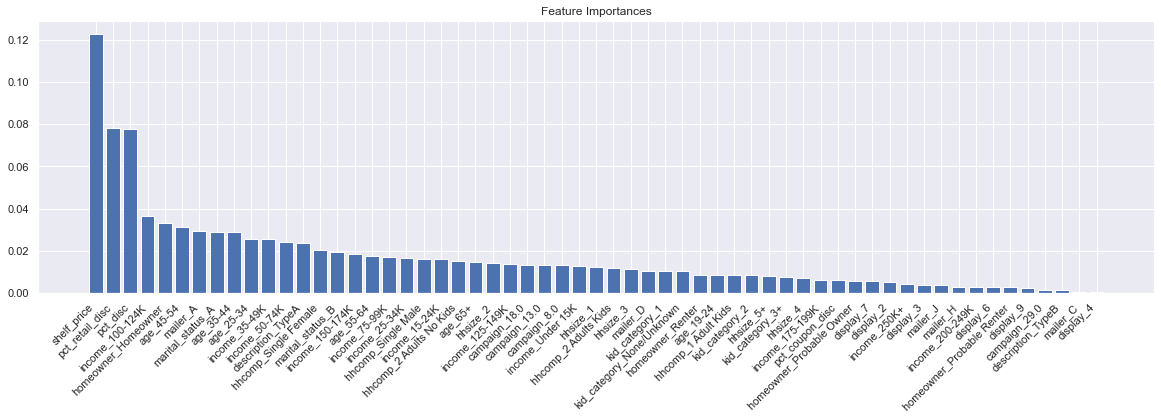

In [73]:
#rf_3 model
importances_3 = rf_3.feature_importances_

indices = np.argsort(importances_3)[::-1]

# rearrange feature names so they match the sorted feature names
# I have my original names list of feature names, which corresponds to the features in the tree.
f_names = [X.columns [i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances_3[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right');

## Monitoring effect of weighting the target variable
The best performing RandomForest Classifier rf_3 is based on weighting the target variable in order to mitigate the unbalanced distribution.
The weighting improves f1, but also seems to improve recall at the cost of precision. Ideally, both should be on a similar level to adequately reflect business needs.
Therefore, an additional Classifier is tuned without weighting the target variable. F1 turns out to be lower. As expected and contrary to the weighted model, the resulting models performs better on precision than on recall.

In [13]:
grid_search_unbalanced = GridSearchCV(rf, param_grid = grid_params, scoring = "f1", cv = cv)
grid_search_unbalanced.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
             estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': [20, 25, 30],
                         'max_samples': [0.5, 0.7, 1],
                         'min_samples_split': [4, 6],
                         'n_estimators': [150, 250, 350]},
             scoring='f1')

In [14]:
grid_search_unbalanced.best_score_

0.6141358085626418

In [15]:
grid_search_unbalanced.best_params_

{'max_depth': 30,
 'max_samples': 0.7,
 'min_samples_split': 6,
 'n_estimators': 250}

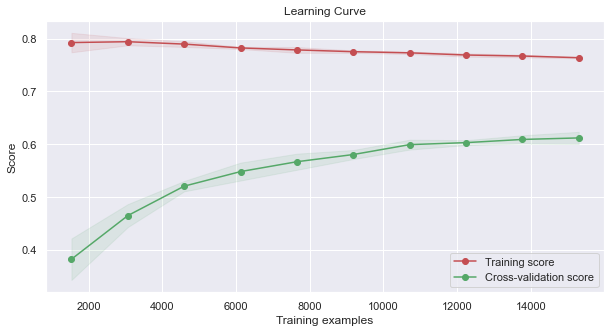

In [16]:
learning_curve = plot_learning_curve(grid_search_unbalanced.best_estimator_, X_train, y_train, cv = cv,  
                          train_sizes = np.linspace(.1, 1, 10), scoring = "f1")           

## Calculate performance of model without weighting

In [17]:
rf_unbalanced = RandomForestClassifier(n_jobs = -1, 
                             max_depth = 30, max_samples = 0.7, min_samples_split = 6, n_estimators = 250)
rf_unbalanced.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, max_samples=0.7, min_samples_split=6,
                       n_estimators=250, n_jobs=-1)

In [18]:
#crossval metrics for rf_unbalanced model
scores = ["f1", "precision", "recall", "accuracy"]

for score in scores:
    list_scores = cross_val_score(rf_unbalanced, X_train, y_train, cv=cv, scoring = score )
    print(list_scores.mean())

0.6203414935407983
0.6968731977228871
0.5616055846422339
0.7688235294117647


In [19]:
y_pred_rf_unbalanced = rf_unbalanced.predict(X_test)
#metrics for rf_unbalanced model - TEST
scores = [f1_score, precision_score, recall_score, accuracy_score]

for score in scores:
    print(score(y_test, y_pred_rf_unbalanced))

0.621517027863777
0.6982608695652174
0.5599721059972106
0.7699364855328158


In [20]:
y_pred_rf_unbalanced_train = rf_unbalanced.predict(X_train)
#metrics for rf_unbalanced model- TRAIN
scores = [f1_score, precision_score, recall_score, accuracy_score]

for score in scores:
    print(score(y_train, y_pred_rf_unbalanced_train))

0.7592207300926801
0.8293388429752067
0.7000348796651552
0.8502352941176471


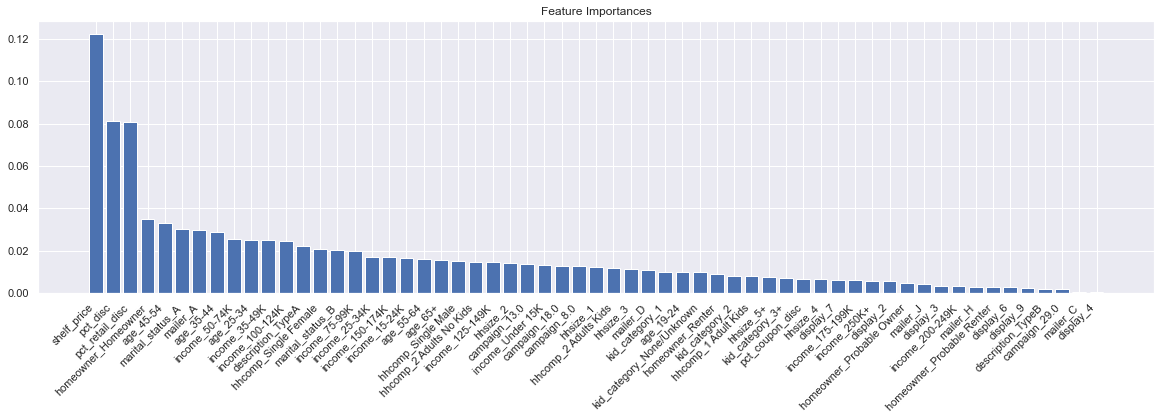

In [21]:
#rf_unbalanced model
importances_unbalanced = rf_unbalanced.feature_importances_

indices = np.argsort(importances_unbalanced)[::-1]

# rearrange feature names so they match the sorted feature names
# I have my original names list of feature names, which corresponds to the features in the tree.
f_names = [X.columns [i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances_unbalanced[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right');